In Part 1 we identified the objective of the project: to predict the 2018 World Series winner using the team offensive statistics for the year 2018.  To accomplish this our plan is to create a model capable of making such a prediction using the team offensive statistics for the years 2000 - 2017 and the a priori information as to which team won the World Series in each of those years.  

We obtained the offensive statistics data and merged it with the world series outcome data.  We are now left with 2 dataframes, one containing the offensive statistics and world series outcomes for the years 2000 - 2017 and another that contains the same features in 2018 minus the world series outcome data.

In this part we will explore the relationships between some of the features with an aim to omit redundant or highly correlated features.  We will also address the issue of missing data.

In [2]:
%%capture
%run Baseball_Project_Part_1.ipynb

In [3]:
total_data.iloc[:10,:]

,Team,Age,G,AB,PA,H,1B,2B,3B,HR,...,Lg,wGDP,Pull%,Cent%,Oppo%,Soft%,Med%,Hard%,TTO%,WSWin
year,,,,,,,,,,,,,,,,,,,,,
2000,Indians,29,1930,5683,6512,1639,1078,310,30,221,...,23.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.1,0.0
2000,Astros,29,2303,5570,6444,1547,973,289,36,249,...,9.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,31.8,0.0
2000,Giants,29,2123,5519,6418,1535,961,304,44,226,...,9.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.7,0.0
2000,White Sox,27,1791,5646,6410,1615,1041,325,33,216,...,23.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.6,0.0
2000,Athletics,28,2066,5560,6432,1501,958,281,23,239,...,23.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33.4,0.0
2000,Angels,28,1839,5628,6373,1574,995,309,34,236,...,23.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.3,0.0
2000,Cardinals,30,2196,5478,6369,1481,962,259,25,235,...,9.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.0,0.0
2000,Rockies,29,2221,5660,6453,1664,1130,320,53,161,...,9.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25.9,0.0
2000,Mariners,30,1985,5497,6444,1481,957,300,26,198,...,23.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,31.8,0.0


Above we can see how the data is organized.  Each row of either dataframe corresponds to a team's yearly offensive statistics with each column representating a specific metric for that team.  The final column is a binary representation as to whether that team in that year won the world series.  Here we can see the first 10 teams in the year 2000 and that the Yankees were the world series champion in that year.  This is shaping up to be a classification problem with a rare class that we are trying to predict.  

Regardless of the model we choose, we first need to deal with missing data.  It would also help if we could omit any redundant highly correlated variables as this type of data can interfere with linear models such as the logistic regression model.  

We will first address the missing data.

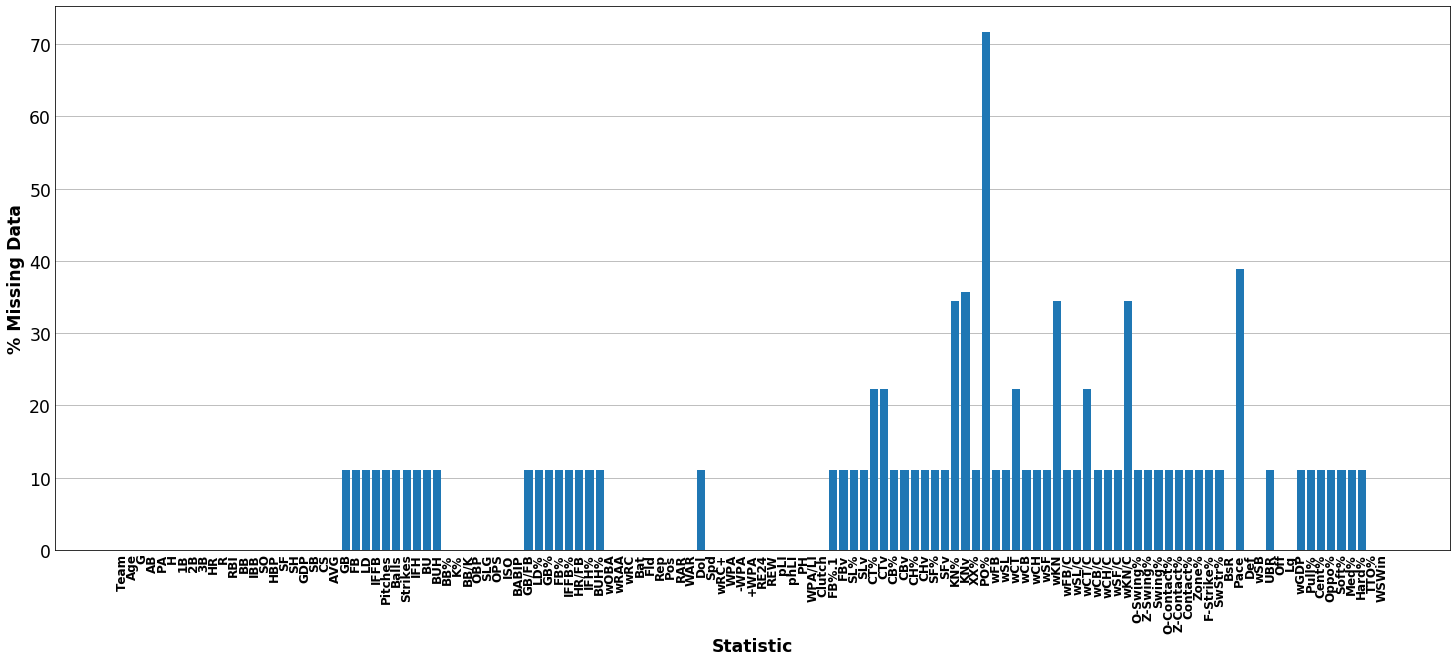

In [4]:
missing_data_count = total_data.isnull().sum()
import matplotlib.pyplot as plt
%matplotlib inline

x = np.linspace(1, len(missing_data_count), len(missing_data_count))
y = missing_data_count.values/total_data.shape[0] * 100

plt.figure(figsize = (25,10))
plt.axes(axisbelow = True)
plt.grid(which = 'major', axis = 'y')
plt.bar(x,y, tick_label = missing_data_count.index);
plt.xticks(rotation = 'vertical', fontsize = 'large', fontweight = 700)
plt.yticks(fontsize = 'xx-large', fontweight = 500)
plt.tick_params(length = 0)
plt.xlabel('Statistic', fontsize = 'xx-large', fontweight = 700);
plt.ylabel('% Missing Data', fontsize = 'xx-large', fontweight = 700);

Here we can see that there are several features that are missing significant amounts of data and one statistic that is missing over 70% of the data!  This is because certain statistics were not measured during the earlier years of our dataset.  Let's eliminate any feature that contains >20% missing data.

In [5]:
total_data_pared = total_data.loc[:, y < 20]
num_over_20 = np.sum((total_data_pared.isnull().sum()/total_data_pared.shape[0] * 100) > 20)
print("\nNumber of features with greater than 20% missing data: {}".format(num_over_20))


Number of features with greater than 20% missing data: 0


Let's make sure we drop the corresponding features from the 2018 data as well.

In [6]:
data_2018_pared = data_2018.loc[:, total_data_pared.columns]
data_2018_pared.shape, total_data_pared.shape

((30, 115), (540, 115))

We've eliminated features with an exortibant amount of missing data, but we still have missing data in the current data set.  Our next task is to fill in the missing data.  This is a prequisite to building a model. We can fill in the data using Scikit Learn's imputer.  

In [7]:
from sklearn.preprocessing import Imputer
imp = Imputer()

total_data_pared.reset_index(drop = True, inplace = True)
data_2018_pared.reset_index(drop = True, inplace = True)

WSWin = total_data_pared.WSWin
Teams = data_2018_pared.Team

total_data_pared.drop(labels = ['WSWin', 'Team'], axis = 1, inplace = True)
data_2018_pared.drop(labels = ['WSWin', 'Team'], axis = 1, inplace = True)

full_data = pd.DataFrame(imp.fit_transform(total_data_pared), columns = total_data_pared.columns)
data_2018_full = pd.DataFrame(imp.fit_transform(data_2018_pared), columns = data_2018_pared.columns)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [8]:
print(full_data.isnull().sum().sum())
print(data_2018_full.isnull().sum().sum())

0
0


We did a few things above to allow for the imputation.  First, we removed the year column from the index because it is no longer necessary to the analysis.  Next, we removed non-numeric columns from the data frames and stored the data in pandas Series that we will use later to create the model.  After this, we created new dataframes of the numeric data with the missing values imputed (filled).  The imputer replaces null values with the mean from the corresponding column.  

Predicting whether a team will win the World Series can be thought of as a classification problem. Each team in a particular year can either fall into the category, or class, of not winning the World Series, or Winning the World series.  This outcome can be described as a binary variable where 0 corresponds to not winning the World Series and 1 corresponds to winning the World Series.  Using Logistic Regression, a model can be constructed to calculate the probabiliy of whether a team falls under class 0 or 1 given the multiple independent variables (e.g. number of home runs, number of hits) for the team that year. After the model is constructed using our data from 2000 - 2017, we can predict the probabiliy of winning the World Series for each team in 2018.

The integrity of predictions made with linear models and generalized linear models is compromised when highly correlated variables exist in the dataset.  In the case where a variable can be essentially reconstructed via a linear combination of other variables we are met with a condition called multicolinearity.  Multicolinearity is not tolerated by logistic regression, and therefore, before we continue with the construction of our model it is important to try and remove highly correlated variables when possible.  We can check the data set for highly corrleated variables using some of Numpy's built in functions.

In [9]:
corr = full_data.corr()
tri_mat = np.triu(np.ones(corr.shape), k = 1)
tri_mask = tri_mat.astype(np.bool)
    
upper = corr.where(tri_mask)
    
corr_list = {}
    
for line in upper.columns:
    if any(abs(upper[line]) > 0.95):
        corr_list[line] = upper[line][abs(upper[line]) > 0.95].index.tolist()

In [10]:
print(corr_list)

{'RBI': ['R'], 'AVG': ['H'], 'BB%': ['BB'], 'K%': ['SO'], 'OPS': ['R', 'RBI', 'SLG'], 'ISO': ['HR'], 'FB%': ['GB/FB'], 'wOBA': ['RBI', 'OPS'], 'wRC': ['R', 'RBI', 'OPS', 'wOBA'], 'WAR': ['RAR'], 'wRC+': ['Bat'], 'REW': ['RE24'], 'CHv': ['FBv'], 'wFB/C': ['wFB'], 'wSL/C': ['wSL'], 'wCB/C': ['wCB'], 'wCH/C': ['wCH'], 'SwStr%': ['Contact%'], 'Off': ['Bat', 'wRC+']}


Here we have calculated the pearson's pairwise correlation coefficients between each pair of variables in our data set.  The result is a correlation matrix that holds the pairwise correlation values.  Correlations close to one indicate extremely correlated variables, which will undermine the effectivness of the logistic regression model.  To mitigate this problem we will find those variables with correlation coefficients 0.95 or greater and remove one of the pair of variables.  

The code above calculates the correlation coefficients and then creates a dictionary which pairs a given variable with its correlated counterpart (if applicable).  By scanning this list we can make an informed decision as to what variables to remove from the dataset to reduce the potential for multicolinearity.  

In [11]:
to_del = ['RBI', 'H', 'BB', 'SO', 'R', 'SLG', 'HR', 'GB/FB', 'OPS', 'wOBA', 'RAR', 'Bat', 'RE24', 'CHv', 'wFB/C', 'wSL/C',
         'wCB/C', 'wCH/C', 'SwStr%', 'Off']

pared_full_data = full_data.drop(labels = to_del, axis = 1)
pared_data_2018 = data_2018_full.drop(labels = to_del, axis =1)
print("Number of features remaining after dropping highly correlated features: {}".format(len(pared_full_data.columns)))

Number of features remaining after dropping highly correlated features: 93


Even after dropping 20 highly correlated features we are still left with 93 features.  Using too many features to fit a model can be problematic, so we will continue to simplify the data set using dimensionality reduction techniques.  Principal components analysis is a method by which features can be assimilated into groups of linear combinations of features, which are ultimately orthogonal.  This solves the problem with any remaining colinearity while reducing the number of features.  

Python's scikit-learn library has built in commands to allow for dimensionality reduction while retaining a specified amount of the original variability within the feature space.

In [12]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

std_full_data = pd.DataFrame(StandardScaler().fit_transform(pared_full_data), columns = pared_full_data.columns)
display(pared_full_data.iloc[:10,:5])
display(std_full_data.iloc[:10,:5])

,Age,G,AB,PA,1B
0,29.0,1930.0,5683.0,6512.0,1078.0
1,29.0,2303.0,5570.0,6444.0,973.0
2,29.0,2123.0,5519.0,6418.0,961.0
3,27.0,1791.0,5646.0,6410.0,1041.0
4,28.0,2066.0,5560.0,6432.0,958.0
5,28.0,1839.0,5628.0,6373.0,995.0
6,30.0,2196.0,5478.0,6369.0,962.0
7,29.0,2221.0,5660.0,6453.0,1130.0
8,30.0,1985.0,5497.0,6444.0,957.0
9,32.0,2061.0,5556.0,6311.0,1017.0


,Age,G,AB,PA,1B
0,0.576192,-2.379600,1.826430,2.592559,1.862578
1,0.576192,0.282182,0.378385,2.003585,0.258151
2,0.576192,-1.002324,-0.275157,1.778389,0.074788
3,-1.431187,-3.371524,1.352291,1.709098,1.297209
4,-0.427497,-1.409085,0.250240,1.899649,0.028948
5,-0.427497,-3.028989,1.121629,1.388627,0.594317
6,1.579882,-0.481386,-0.800554,1.353982,0.090069
7,0.576192,-0.302982,1.531695,2.081538,2.657151
8,1.579882,-1.987112,-0.557077,2.003585,0.013667
9,3.587261,-1.444765,0.198982,0.851622,0.930483


In [13]:
pca = PCA(n_components = .90, svd_solver = 'full', random_state = 42)
data_transformed = pca.fit_transform(std_full_data)

strings = []
for number in range(1, pca.n_components_ + 1):
    strings.append("component_" + str(number))
    
full_data_trans = pd.DataFrame(data = data_transformed, columns = strings)

full_data_trans.iloc[:5]
print("Number of components: {}".format(pca.n_components_))

Number of components: 29


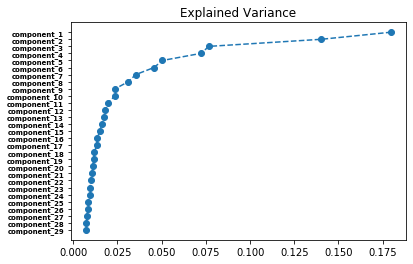

In [14]:
x = np.linspace(1, pca.n_components_, pca.n_components_)
y = pca.explained_variance_ratio_

plt.figure()
plt.plot(y[::-1], strings[::-1], 'o--');
plt.yticks(fontsize = 'x-small', fontweight = '600');
plt.title('Explained Variance');

Before transforming the data using scikit-learn's PCA library we must first standardize the values in the dataframe.  Standardization prevents the PCA analysis from being too heavily influenced by variables with large numeric values.  After standarization we can generate a pca object and transform the data into components that explain 90% of the variance.  

Our plot and output shows that 90% of the variance can be described using 29 components, which is less than one third of the number of features before the transformation.  This will help speed up the machine learning logistic regression algorithm and removes the colinearity problem.  Another benefit of avoiding colinearity is that we can more confidently interpret the coefficients generated by the logistic regression model and potentially tease out which features are most predictive of a world series championship.

The PCA transformation applied here was done on the entirety of the data set (excluding the 2018 data).  However, when we generate our logistic regression model we will want to split the data into training and test sets to allow us to validate the model.  Therefore, in order to move forward properly we will first want to split the data into training and test sets, then apply the PCA transformation.  This will mimic what the model will actually do when applied to the 2018 data.  The steps will be to 1) PCA transform the training data 2) apply that same transformation to the test data 3) build the model using the training data 4) apply the model to test data to predict the probability of a world series win and 5) assess the model accuracy.  The final steps in this part of the project will be to split up the data into training and test sets, and then apply PCA accordingly.

In [15]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(pared_full_data, WSWin, random_state = 42, stratify = WSWin)
print("Number of training samples: {}\nNumber of testing samples: {}".format(x_train.shape[0], x_test.shape[0]))
print("Percent of world series winner class in training set: {:.3f}".format(y_train.sum()/y_train.shape[0]))
print("Percent of world series winner class in training set: {:.3f}".format(y_test.sum()/y_test.shape[0]))

Number of training samples: 405
Number of testing samples: 135
Percent of world series winner class in training set: 0.035
Percent of world series winner class in training set: 0.030


In [16]:
sc = StandardScaler()
x_train_std = pd.DataFrame(sc.fit_transform(x_train), columns = x_train.columns, index = x_train.index)
x_test_std = pd.DataFrame(sc.transform(x_test), columns = x_test.columns, index = x_test.index)

In [17]:
pca_new = PCA(n_components = .90, svd_solver = 'full', random_state = 42)

x_train_pca = pd.DataFrame(pca_new.fit_transform(x_train_std), 
                           columns = ["component_" + str(number) for number in range(1, pca_new.n_components_ + 1)],
                           index = x_train_std.index)
x_test_pca = pd.DataFrame(pca_new.transform(x_test_std),
                           columns = ["component_" + str(number) for number in range(1, pca_new.n_components_ + 1)],
                           index = x_test_std.index)
display(x_train_pca.iloc[:10,:5])
display(x_test_pca.iloc[:10,:5])

,component_1,component_2,component_3,component_4,component_5
138,-1.900573,3.223267,-1.234369,-2.927883,-0.378919
69,-2.320558,5.662653,0.750492,0.100631,7.134093
46,-0.060104,-0.025723,-0.067966,-1.568574,-0.724040
103,-2.094390,5.759249,-0.600315,-2.513443,2.251149
536,3.444575,-3.342297,2.341375,1.142305,-1.476530
265,3.150775,0.541679,2.099961,-2.123162,-2.973928
411,3.749198,-0.649745,-3.795343,4.740411,-0.239344
182,-5.544482,-1.796883,2.519675,0.330592,1.388409
290,0.896020,-0.498354,0.448753,-4.318735,-3.544361
165,0.040620,4.398759,1.403904,1.288465,1.483515


,component_1,component_2,component_3,component_4,component_5
514,-0.112691,-6.973221,-0.191027,-4.792530,1.310351
371,0.358919,-2.783939,1.112886,1.628206,0.040005
445,3.729884,-2.176719,0.572937,-1.567572,-2.009185
213,-6.264537,-1.970740,-1.024141,1.677700,0.996672
526,0.909438,-5.590645,2.153182,1.075747,0.785076
458,2.058667,-3.519933,-5.917989,-0.269820,1.868672
208,3.417407,2.874965,2.849095,1.247432,0.806165
91,-8.004012,1.316611,-1.653062,-2.919431,4.194459
268,4.757567,4.042656,-4.130564,2.022413,-0.913006
50,2.467313,-0.717404,0.943077,-3.075454,0.214851


The data contains two classes (WS Win and not WS Win) that are imbalanced.  Upon splitting the data into testing and training sets we invoke test_train_split's stratification feature to ensure that the proportion of classes is similar in the testing and training subsets. By doing so we ensure that the model is being built using data that contains the proper proportion of classes and that the model is being tested on data that has a similar class proportion.  This will ultimately mimic the real life scenario we are trying to predict (there is only one WS winner per year so we know the class proportion is fixed). 

After splitting the data PCA is applied. The y or label data series does not need to be transformed in any way - these are simply the labels that correspond to whether a team won the world series or not for a particular row.  We are now ready to move on to part 3, which will include generating, validating, and applying the logistic regression model